# Active Learning para a base de dados de Secretarias do DODF

O código a seguir implementa um algoritmo de Active Learning usando Support Vector Machine (SVM) para a base de dados de secretarias do DODF. 

Para a escolha das instâncias a serem rotuladas, foram implementadas duas abordagens: distância da instância para o hiperplano e o algoritmo Best vs Second Best (BvSB).

In [0]:
'''
    dodf_simple

    Active learning with Support Vector Machine
    baseado no trabalho do aluno Hichemm Khalid Medeiros
'''
import re
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


In [0]:
def cleanText(text):
    '''Normalização do texto retirando acentuação, caracteres especiais,
       espaços adicionais e caracteres não textuais'''

    text = text.lower()
    text = re.sub(r"ú", "u", text)
    text = re.sub(r"á", "a", text)
    text = re.sub(r"é", "e", text)
    text = re.sub(r"í", "i", text)
    text = re.sub(r"ó", "o", text)
    text = re.sub(r"u", "u", text)
    text = re.sub(r"â", "a", text)
    text = re.sub(r"ê", "e", text)
    text = re.sub(r"ô", "o", text)
    text = re.sub(r"à", "a", text)
    text = re.sub(r"ã", "a", text)
    text = re.sub(r"õ", "o", text)
    text = re.sub(r"ç", "c", text)
    text = re.sub(r"\\W", " ", text)
    text = re.sub(r"\\s+", " ", text)
    text = text.strip(' ')
    return text


def clfTest(clf):
    '''Faz as classificacoes e mostra a f1-score resultante'''

    pred = clf.predict(X_test)

    return metrics.f1_score(y_test, pred, average='micro')

## Best vs Second Best

Esse algoritmo é descrito no artigo [Multi-Class Active Learning for Image Classification](https://www.merl.com/publications/docs/TR2009-034.pdf) e consiste em calcular a diferença na probabilidade da instância pertencer à classe mais provável e a probabilidade de pertencer à segunda classe mais provável. As instâncias em que essa diferença for menor são as que devem ser rotuladas a seguir.

In [0]:
def benchmarkBvSB(clf):
    '''Processamento do conjunto de treinamento e escolha dos exemplos a serem rotulados usando o algoritmo Best vs Second Best'''

    clf.fit(X_train, y_train)

    probabilities = clf.predict_proba(X_unlabeled)

    BvSB = []
    for list in probabilities:
        list = list.tolist()
        best = list.pop(list.index(max(list)))
        second_best = list.pop(list.index(max(list)))
        BvSB.append(best-second_best)

    df = pd.DataFrame(clf.predict(X_unlabeled))
    df = df.assign(conf = BvSB)
    df.columns = ['label', 'conf']
    df.sort_values(by=['conf'], ascending=True, inplace=True)
    question_samples = []

    for category in categories:
        low_confidence_samples = df[df.label == category].conf.index[0:NUM_QUESTIONS]
        question_samples.extend(low_confidence_samples.tolist())
        df.drop(index=df[df.label == category][0:NUM_QUESTIONS].index, inplace=True)

    return question_samples

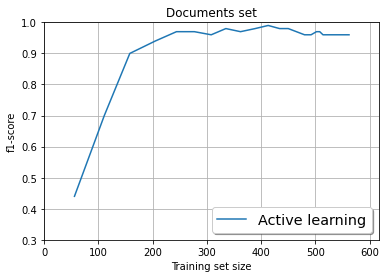

In [7]:
estimator = LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-3, class_weight='balanced')
classifier = CalibratedClassifierCV(base_estimator=estimator, cv=2)

# Quantidade de requisicoes de rotulos para o oraculo que serao feitas por vez
NUM_QUESTIONS = 3

PATH_TRAIN = "dodftrain.csv"
ENCODING = 'utf-8'
result_x = []
result_y = []

df = pd.read_csv(PATH_TRAIN,encoding = ENCODING,header = 0)
df['label'] = df['label'].map(lambda com: cleanText(com))
df['text'] = df['text'].map(lambda com: cleanText(com))

categories = df.label.unique()

"""Divisao do dataset entre informacoes de treinamento e teste:"""

# df_test = df.sample(frac = 0.33, random_state = 1)
df_test = df.sample(n=100, random_state = 1)

df_train = df.drop(index = df_test.index)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

MAX_SIZE = df_train.label.size

"""Cria o dataframe com os exemplos rotulados:
*    Seleciona um exemplo para cada rotulo
"""

df_labeled = pd.DataFrame()

for index, category in enumerate(categories):
    df_labeled = df_labeled.append( df_train[df_train.label==category][0:3], ignore_index=True )
    df_train.drop(index = df_train[df_train.label==category][0:3].index, inplace=True)

df_unlabeled = df_train

df_train = df_labeled

# Active learning : loop

while True:

    y_train = df_train.label
    y_test = df_test.label

    df_unlabeled = df_unlabeled.reset_index(drop=True)

    vectorizer = TfidfVectorizer(encoding= ENCODING, use_idf=True, norm='l2', binary=False, sublinear_tf=True,min_df=0.0001, max_df=1.0, ngram_range=(1, 3), analyzer='word', stop_words=None)

    X_train = vectorizer.fit_transform(df_train.text)
    X_test = vectorizer.transform(df_test.text)
    X_unlabeled = vectorizer.transform(df_unlabeled.text)

    df_unified = df_train.append(df_unlabeled)
    X_unified  = vectorizer.transform(df_unified.text)

    question_samples = benchmarkBvSB(classifier)
    result_x.append(clfTest(classifier))
    result_y.append(df_train.label.size)

    if (df_train.label.size < MAX_SIZE - (len(categories) * NUM_QUESTIONS + 1)) and ((len(result_x) < 2) or ( (result_x[-1] - result_x[-2] > -1) or (result_x[-1] < result_x[-2]) )):
        insert = {'label':[], 'text':[]}
        cont = 0
        for i in question_samples:
            try:
                insert["label"].insert(cont, df_unlabeled.label[i])
                insert["text"].insert(cont, df_unlabeled.text[i])
                cont += 1
                df_unlabeled = df_unlabeled.drop(i)
            except Exception as e:
                print("Error:", e)

        df_insert = pd.DataFrame.from_dict(insert)
        df_train = df_train.append(df_insert, ignore_index=True, sort=False)

    else:
        result_y_active = result_y
        result_x_active = result_x
        plt.plot(result_y_active, result_x_active, label='Active learning')
        plt.axis([0, MAX_SIZE, 0.3, 1.0])
        plt.legend(loc='lower right', shadow=True, fontsize='x-large')
        plt.grid(True)
        plt.xlabel('Training set size')
        plt.ylabel('f1-score')
        plt.title('Documents set')
        plt.show()

        result = pd.DataFrame(result_y)
        result = result.assign(y=result_x)
        np.savetxt('results.txt', result, fmt='%f')

        break

    # end

## Distância para o hiperplano

Para essa abordagem, foi usado o método [decision_function()](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function) do classificador [LinearSVC()](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) para a escolha das instâncias a serem rotuladas. 

In [0]:
def benchmark(clf):
    '''Processamento do conjunto de treinamento e escolha dos exemplos a serem rotulados'''

    clf.fit(X_train, y_train)

    confidences = clf.decision_function(X_unlabeled)

    df = pd.DataFrame(clf.predict(X_unlabeled))
    df = df.assign(conf = confidences.max(1))
    df.columns = ['label', 'conf']
    df.sort_values(by=['conf'], ascending=False, inplace=True)
    question_samples = []

    for category in categories:
        low_confidence_samples = df[df.label == category].conf.index[0:NUM_QUESTIONS]
        question_samples.extend(low_confidence_samples.tolist())
        df.drop(index=df[df.label == category][0:NUM_QUESTIONS].index, inplace=True)

    return question_samples

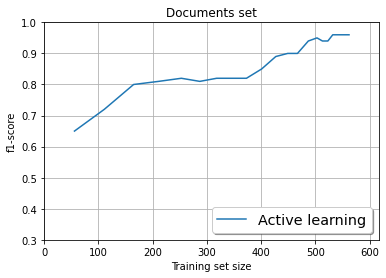

In [9]:
estimator = LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-3, class_weight='balanced')

# Quantidade de requisicoes de rotulos para o oraculo que serao feitas por vez
NUM_QUESTIONS = 3

PATH_TRAIN = "dodftrain.csv"
ENCODING = 'utf-8'
result_x = []
result_y = []

df = pd.read_csv(PATH_TRAIN,encoding = ENCODING,header = 0)
df['label'] = df['label'].map(lambda com: cleanText(com))
df['text'] = df['text'].map(lambda com: cleanText(com))

categories = df.label.unique()

"""Divisao do dataset entre informacoes de treinamento e teste:"""

# df_test = df.sample(frac = 0.33, random_state = 1)
df_test = df.sample(n=100, random_state = 1)

df_train = df.drop(index = df_test.index)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

MAX_SIZE = df_train.label.size

"""Cria o dataframe com os exemplos rotulados:
*    Seleciona um exemplo para cada rotulo
"""

df_labeled = pd.DataFrame()

for index, category in enumerate(categories):
    df_labeled = df_labeled.append( df_train[df_train.label==category][0:3], ignore_index=True )
    df_train.drop(index = df_train[df_train.label==category][0:3].index, inplace=True)

df_unlabeled = df_train

df_train = df_labeled

# Active learning : loop

while True:

    y_train = df_train.label
    y_test = df_test.label

    df_unlabeled = df_unlabeled.reset_index(drop=True)

    vectorizer = TfidfVectorizer(encoding= ENCODING, use_idf=True, norm='l2', binary=False, sublinear_tf=True,min_df=0.0001, max_df=1.0, ngram_range=(1, 3), analyzer='word', stop_words=None)

    X_train = vectorizer.fit_transform(df_train.text)
    X_test = vectorizer.transform(df_test.text)
    X_unlabeled = vectorizer.transform(df_unlabeled.text)

    df_unified = df_train.append(df_unlabeled)
    X_unified  = vectorizer.transform(df_unified.text)

    question_samples = benchmark(estimator)
    result_x.append(clfTest(estimator))
    result_y.append(df_train.label.size)

    if (df_train.label.size < MAX_SIZE - (len(categories) * NUM_QUESTIONS + 1)) and ((len(result_x) < 2) or ( (result_x[-1] - result_x[-2] > -1) or (result_x[-1] < result_x[-2]) )):
        insert = {'label':[], 'text':[]}
        cont = 0
        for i in question_samples:
            try:
                insert["label"].insert(cont, df_unlabeled.label[i])
                insert["text"].insert(cont, df_unlabeled.text[i])
                cont += 1
                df_unlabeled = df_unlabeled.drop(i)
            except Exception as e:
                print("Error:", e)

        df_insert = pd.DataFrame.from_dict(insert)
        df_train = df_train.append(df_insert, ignore_index=True, sort=False)

    else:
        result_y_active = result_y
        result_x_active = result_x
        plt.plot(result_y_active, result_x_active, label='Active learning')
        plt.axis([0, MAX_SIZE, 0.3, 1.0])
        plt.legend(loc='lower right', shadow=True, fontsize='x-large')
        plt.grid(True)
        plt.xlabel('Training set size')
        plt.ylabel('f1-score')
        plt.title('Documents set')
        plt.show()

        result = pd.DataFrame(result_y)
        result = result.assign(y=result_x)
        np.savetxt('results.txt', result, fmt='%f')

        break

    # end

Comparando os gráficos F1-score vs Tamanho do conjunto de treinamento dos dois métodos, é possível observar que o algoritmo BvSB resulta em uma curva cujo coeficiente angular é bem maior inicialmente e que chega a um f1-score bastante aceitável com bem menos exemplos de treinamento.

A fim de melhor entendimento, o código a seguir mostra a ordem em que os exemplos serão escolhidos pelos dois métodos. As instâncias que estão mais no início do dataframe, lembrando que ele foi ordenado de acordo com cada abordagem, serão escolhidas primeiro para serem rotuladas.

In [10]:
estimator = LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-3, class_weight='balanced')
clf = CalibratedClassifierCV(base_estimator=estimator, cv=2)

PATH_TRAIN = "dodftrain.csv"
ENCODING = 'utf-8'

df = pd.read_csv(PATH_TRAIN,encoding = ENCODING,header = 0)
df['label'] = df['label'].map(lambda com: cleanText(com))
df['text'] = df['text'].map(lambda com: cleanText(com))

categories = df.label.unique()

"""Divisao do dataset entre informacoes de treinamento e teste:"""

df_test = df.sample(n=100, random_state = 1)

df_train = df.drop(index = df_test.index)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

"""Cria o dataframe com os exemplos rotulados:
*    Seleciona um exemplo para cada rotulo
"""

df_labeled = pd.DataFrame()

for index, category in enumerate(categories):
    df_labeled = df_labeled.append( df_train[df_train.label==category][0:5], ignore_index=True )
    df_train.drop(index = df_train[df_train.label==category][0:5].index, inplace=True)

df_unlabeled = df_train[0:7]

df_train = df_labeled


y_train = df_train.label
y_test = df_test.label

df_unlabeled = df_unlabeled.reset_index(drop=True)

vectorizer = TfidfVectorizer(encoding= ENCODING, use_idf=True, norm='l2', binary=False, sublinear_tf=True,min_df=0.0001, max_df=1.0, ngram_range=(1, 3), analyzer='word', stop_words=None)

X_train = vectorizer.fit_transform(df_train.text)
X_test = vectorizer.transform(df_test.text)
X_unlabeled = vectorizer.transform(df_unlabeled.text)

df_unified = df_train.append(df_unlabeled)
X_unified  = vectorizer.transform(df_unified.text)


clf.fit(X_train, y_train)

probabilities = clf.predict_proba(X_unlabeled)

BvSB = []
for list in probabilities:
    list = list.tolist()
    best = list.pop(list.index(max(list)))
    second_best = list.pop(list.index(max(list)))
    BvSB.append(best-second_best)

df = pd.DataFrame(clf.predict(X_unlabeled))
df = df.assign(conf = BvSB)
df.columns = ['label', 'conf']
df.sort_values(by=['conf'], ascending=True, inplace=True)

print('**************Best vs Second Best**************')
print(df)
print()


estimator.fit(X_train, y_train)

confidences = estimator.decision_function(X_unlabeled)

df = pd.DataFrame(estimator.predict(X_unlabeled))
df = df.assign(conf = confidences.max(1))
df.columns = ['label', 'conf']
df.sort_values(by=['conf'], ascending=False, inplace=True)

print('**************Decision Function**************')
print(df)

**************Best vs Second Best**************
                                               label      conf
2                                    poder executivo  0.093875
5             tribunal de contas do distrito federal  0.120231
6          secretaria de estado de seguranca publica  0.216241
0          secretaria de estado de seguranca publica  0.288194
3          secretaria de estado de seguranca publica  0.314765
1  secretaria de estado de fazenda, planejamento,...  0.331893
4  secretaria de estado de fazenda, planejamento,...  0.465399

**************Decision Function**************
                                               label      conf
3          secretaria de estado de seguranca publica  0.232400
1  secretaria de estado de fazenda, planejamento,...  0.189277
0          secretaria de estado de seguranca publica -0.001061
4  secretaria de estado de fazenda, planejamento,... -0.500846
6          secretaria de estado de seguranca publica -0.511562
2                      